In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import time

import torch
print(torch.__version__)
# import torch.nn as nn
# import torch.nn.functional as F

np.random.seed(0)
torch.manual_seed(0)

# get device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device is:', device)
print(torch.cuda.get_device_name(0))

2.3.0+cu121
device is: cuda
NVIDIA L4


# Related functions (must run)

In [2]:
def bisect_index(n_bisect, x_data, indx_sorted_x, lb, ub, p_low=0.45, p_high=0.55, max_edge_ratio=5, device=device):
    ### n_bisect stand for the number of iteration, will produce 2**n partitions based on x_data
    ### x_data should be a tensor of size n_samples * d_X, where d_X is the dimension of space X
    ### indx_sorted_x is an torch integer tensor of size n_samples * d indicating the indeces for ascending order, it should resemble X.sort(0)[1]
    ### lb, ub should be torch tensors of length d_X
    ### return a triplet representing partitions
    ### first entry is boolean tensor of size (2**n_bisect) * n_samples, each row represents the x's that falls into that part
    ### second and third entries are float tensor of size (2**n_bisect) * d_X, respetively indicating the lower and upper bounds of the covering rectangle

    # in case n_bisect too large
    while 2**n_bisect > x_data.shape[0]:
        n_bisect = int(n_bisect - 1)

    # initialize
    partition_bool = torch.zeros((2**n_bisect, x_data.shape[0]), dtype=torch.bool, device=device)
    partition_lb = torch.ones((2**n_bisect, x_data.shape[1]), device=device) * lb
    partition_ub = torch.ones((2**n_bisect, x_data.shape[1]), device=device) * ub
    partition_bool[0] = True
    dim_rand = torch.randint(0, x_data.shape[1], size=(2**n_bisect,))
    p_rand = p_low + (p_high-p_low) * torch.rand(size=(2**n_bisect,))

    # tiling
    for k in range(n_bisect):
        i_mid = int(2 ** k)
        for i in range(i_mid):
            split_to =  int(i_mid + i)
            p_, dim_ = p_rand[split_to], int(dim_rand[split_to])
            edge_len = partition_ub[i]-partition_lb[i]
            if torch.max(edge_len) >= max_edge_ratio * torch.min(edge_len):
                dim_ = torch.argmax(edge_len)
            j_mid = int(torch.sum(partition_bool[i]) * p_)
            temp = partition_bool[i][indx_sorted_x[:, dim_]]
            temp = torch.masked_select( indx_sorted_x[:, dim_], temp)
            ## split one rectangle into two for partition_lb and partition_ub
            partition_lb [split_to], partition_ub[split_to] = partition_lb[i], partition_ub[i]
            partition_ub[i, dim_], partition_lb[split_to, dim_] = x_data[temp[j_mid] , dim_], x_data[temp[j_mid-1] , dim_]
            ## split one rectangle into two for partition_bool
            partition_bool[split_to][temp[j_mid:]] = True
            partition_bool[i][temp[j_mid:]] = False

    return partition_bool, partition_lb, partition_ub

def get_anns_rbsp_distances(x_data, k, partition_bool, partition_lb, partition_ub, n_part_batch = 1, ratio_skip = 1, device = torch.device('cpu')):
    ### x_data should be of size n_samples * d_X
    ### this function will first generate uniformly n_part_batch many x within each partition characterized by partition_lb and partition_ub
    ### then group x_data in the neighborhood of x within the same partition characterized by partition_bool, the neighborhood is specified as the k-nearest neighbor
    ### return average distance of nearest neighbors to x

    n_part = partition_bool.shape[0]
    partition_lb_interleave, partition_ub_interleave = torch.repeat_interleave(partition_lb, n_part_batch, dim=0), torch.repeat_interleave(partition_ub, n_part_batch, dim=0)
    x_batch_ = partition_lb_interleave + (partition_ub_interleave - partition_lb_interleave) * torch.rand(size=(n_part * n_part_batch, x_data.shape[1]), device=device)
    x_batch = torch.zeros_like(x_batch_)
    distances = torch.zeros(n_part * n_part_batch, k, device=device)
    i_ = 0

    for i in range(n_part):
        bool_array = partition_bool[i]
        # print(torch.sum(bool_array))
        if torch.sum(bool_array) < ratio_skip * k:
            # print(torch.sum(bool_array))
            continue
        x_data_part = x_data[bool_array]
        x_query_part = x_batch_[i*n_part_batch:(i+1)*n_part_batch] # query points
        distances_part = torch.sum(torch.abs( x_data_part.unsqueeze(0) - x_query_part.unsqueeze(1) ), -1)
        distances[i_*n_part_batch: (i_+1)*n_part_batch, :] = distances_part.sort(-1)[0][:, :k]
        x_batch[i_*n_part_batch: (i_+1)*n_part_batch ] = x_query_part
        i_ = i_ + 1

    return torch.mean(distances, -1), x_batch

def get_nns_distances(x_data, k, n_batch=256, x_batch=None, device=torch.device('cpu'), bool_forloop=False):
    ### x_data should be of size n_samples * d_X, where d_X = x_data.shape[1]
    ### this function will first generate uniformly a batch of x in [0,1]^d_X
    ### then group x_data in the neighborhood of x, the neighborhood is specified as the k-nearest neighbor
    ### return sum of distances of exact nearest neighbors to each x

    if x_batch is None:
        x_batch = torch.rand(n_batch, x_data.shape[1], device=device)

    if bool_forloop:
        distances = torch.zeros(n_batch, device=device)
        for i in range(n_batch):
           distances[i] = torch.sum( torch.sum(torch.abs(x_data - x_batch[i]), -1).sort()[0][:k] ) / k
        return distances
    else:
        return torch.mean(torch.sum( torch.abs( x_data.unsqueeze(0) - x_batch.unsqueeze(1) ), -1).sort(-1)[0][:, :k], -1)



# Plot an illustration of ANNS-RBSP

<ipython-input-3-886685ea1f19>:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('hsv', partition_lb.shape[0])


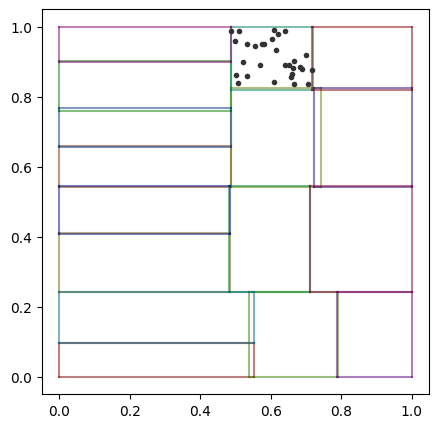

This block takes 0.80 seconds.


In [ ]:
time_start = time.time()

n_samples = int(5e2)
n_bisect = 4
d = 2
x_data = torch.rand(size=(n_samples, d), device=device)
_, indx_sorted_d = x_data.sort(0)
lb = torch.zeros(d, device=device)
ub = torch.ones(d, device=device)

partition_bool, partition_lb, partition_ub = bisect_index(n_bisect, x_data, indx_sorted_d, lb, ub, p_low=0.45, p_high=0.55,  max_edge_ratio=3, device=device)

plt.figure(figsize=[5,5])
colors = plt.cm.get_cmap('hsv', partition_lb.shape[0])
for i in range(partition_lb.shape[0]):
    color = np.array(colors(i))* 0.5
    lb_, ub_ = partition_lb[i].detach().cpu().numpy(), partition_ub[i].detach().cpu().numpy()
    plt.plot([lb_[0], ub_[0]], [lb_[1], lb_[1]], color=color)
    plt.plot([lb_[0], ub_[0]], [ub_[1], ub_[1]], color=color)
    plt.plot([lb_[0], lb_[0]], [lb_[1], ub_[1]], color=color)
    plt.plot([ub_[0], ub_[0]], [lb_[1], ub_[1]], color=color)

j = 7
x_data_j = x_data[partition_bool[j]].detach().cpu().numpy()
plt.plot(x_data_j[:,0], x_data_j[:,1], '.',  color=[0.2]*3)

plt.show()

time_end = time.time()
print('This block takes %.2f seconds.' % (time_end-time_start))

# Compare execution time

In [22]:
n_samples = int(1e4)
d_X = 1
k = 300
n_batch = 256
n_bisect = 5
n_part_batch = 8

# generate data
x_data = torch.rand(n_samples, d_X, device=device)

# prepare for rbsp
t_pre_start = time.time()
indx_sorted_x = x_data.sort(0)[1]
lb = torch.min(x_data, 0)[0]
ub = torch.max(x_data, 0)[0]
t_pre_end = time.time()
print('Preparation takes %.2f seconds' % (t_pre_end-t_pre_start))

Preparation takes 0.00 seconds


## Time exact nearest neighbor search

In [23]:
bool_forloop = False # Setting to False uses 3d tensor, but may run out of memory

x_batch = torch.rand((n_batch, d_X),device=device)

t_search_start = time.time()
for _ in range(100):
    ave_actual = get_nns_distances(x_data, k, n_batch, device=device, bool_forloop=bool_forloop)
t_search_end = time.time()

print('Exact search takes %.2f seconds' % (t_search_end-t_search_start))

Exact search takes 0.03 seconds


## Time ANNS-RBSP

In [24]:
t_search_start = time.time()
for _ in range(100):
    partition_bool, partition_lb, partition_ub = bisect_index(n_bisect, x_data, indx_sorted_x, lb, ub, p_low=0.45, p_high=0.55, max_edge_ratio=5, device=device)
    ave_rbsp = get_anns_rbsp_distances(x_data, k, partition_bool, partition_lb, partition_ub, n_part_batch = n_part_batch, ratio_skip = 1, device=device)
t_search_end = time.time()

print('Approximate search takes %.2f seconds' % (t_search_end-t_search_start))

Approximate search takes 2.17 seconds


# Compare distances (averaged over k nearest neighbors)

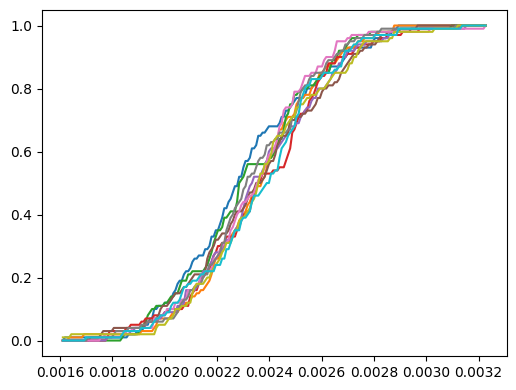

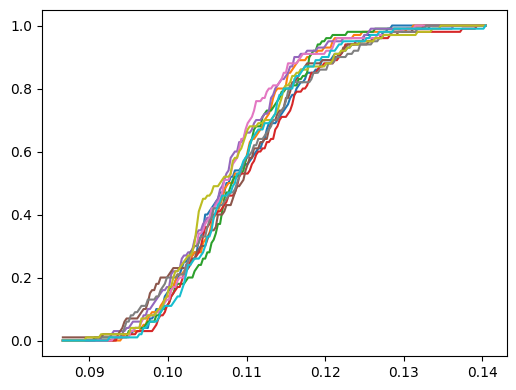

This block takes 439.25 seconds.


In [3]:
t_start = time.time()
n_samples = int(1e6)
d_X_lst = [3, 10]
k = 300
n_bisect = 5
n_part_batch = 8
n_batch = 2**n_bisect * n_part_batch
n_iter = 100 # n_iter sets of 256 query points, 1 data set
n_repeat = 10 # repeat the above for n_repeat data set
bool_forloop = True # Setting to False uses 3d tensor, can be memory demanding

for _ in range(len(d_X_lst)):
    d_X = d_X_lst[_]
    diff_record = torch.zeros(n_repeat, n_iter, device=device)
    # simulate
    for i in range(n_repeat):
        x_data = torch.rand(n_samples, d_X, device=device)
        indx_sorted_x = x_data.sort(0)[1]
        lb, ub = torch.zeros(d_X, device=device), torch.ones(d_X, device=device)
        for j in range(n_iter):
            partition_bool, partition_lb, partition_ub = bisect_index(n_bisect, x_data, indx_sorted_x, lb, ub, p_low=0.45, p_high=0.55, max_edge_ratio=5, device=device)
            distances_rbsp, x_batch = get_anns_rbsp_distances(x_data, k, partition_bool, partition_lb, partition_ub, n_part_batch = n_part_batch, ratio_skip = 1, device=device)
            distances_actual = get_nns_distances(x_data, k, x_batch=x_batch, device=device, bool_forloop=bool_forloop)
            diff_record[i,j] = torch.mean(distances_rbsp - distances_actual)
    # plot
    plt.figure(figsize=(6,4.5))
    n_plot = 200
    diff_plot = torch.linspace(diff_record.min().item(), diff_record.max().item(), n_plot, device=device)
    diff_cdf = torch.zeros(n_repeat, n_plot, device=device)
    for l in range(n_plot):
        diff_cdf[:, l] = torch.sum(diff_record <= diff_plot[l], -1) / n_iter
    for i in range(n_repeat):
        plt.plot(diff_plot.detach().cpu().numpy(), diff_cdf[i].detach().cpu().numpy())
    plt.show()

t_end = time.time()
print("This block takes %.2f seconds." % (t_end-t_start))